Error: 'House_Rent_Dataset.csv' not found. Please check the file path.
Using a dummy dataset for demonstration.

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          5 non-null      object
 1   BHK                5 non-null      int64 
 2   Rent               5 non-null      int64 
 3   Size               5 non-null      int64 
 4   Floor              5 non-null      object
 5   Area Type          5 non-null      object
 6   Area Locality      5 non-null      object
 7   City               5 non-null      object
 8   Furnishing Status  5 non-null      object
 9   Tenant Preferred   5 non-null      object
 10  Bathroom           5 non-null      int64 
 11  Point of Contact   5 non-null      object
dtypes: int64(4), object(8)
memory usage: 612.0+ bytes

--- First 5 Rows ---
    Posted On  BHK   Rent

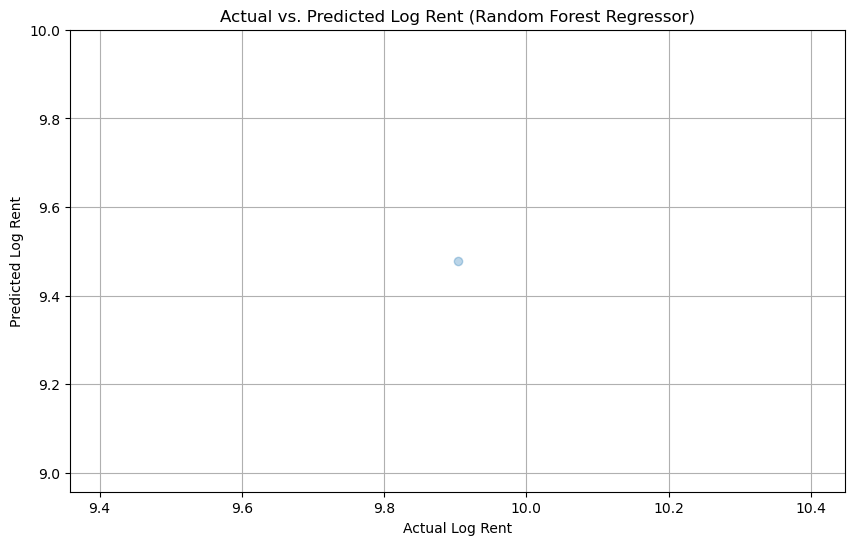

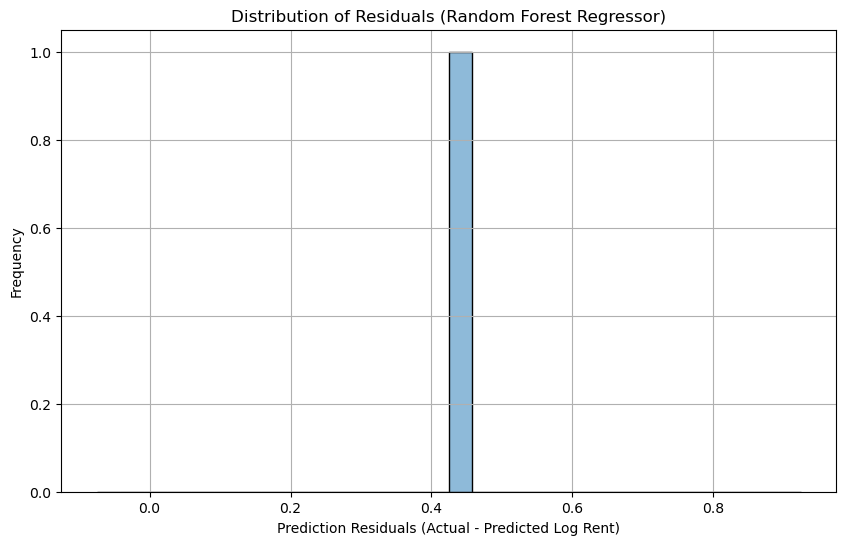


--- Saving Model and Scaler ---
Model, scaler, and feature names saved successfully.

--- Loading Model and Scaler for Prediction ---
Model, scaler, and feature names loaded successfully.

--- Enter House Details for Prediction ---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import joblib # Import joblib for saving and loading models

# Suppress warnings for cleaner output
warnings.simplefilter('ignore')

# --- 1. Data Loading ---
# Load the dataset. Make sure the path to your CSV file is correct.
# If running in Kaggle, the path '/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv'
# should work. For local execution, adjust the path accordingly.
try:
    df = pd.read_csv('/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'House_Rent_Dataset.csv' not found. Please check the file path.")
    # Create a dummy DataFrame for demonstration if the file is not found
    data = {
        'Posted On': ['2022-05-18', '2022-05-13', '2022-05-16', '2022-07-04', '2022-05-09'],
        'BHK': [2, 2, 2, 2, 2],
        'Rent': [10000, 20000, 17000, 10000, 7500],
        'Size': [1100, 800, 1000, 800, 850],
        'Floor': ['Ground out of 2', '1 out of 3', '1 out of 3', '1 out of 2', '1 out of 2'],
        'Area Type': ['Super Area', 'Super Area', 'Super Area', 'Super Area', 'Carpet Area'],
        'Area Locality': ['Bandel', 'Phool Bagan, Kankurgachi', 'Salt Lake City Sector 2', 'Dumdum Park', 'South Dum Dum'],
        'City': ['Kolkata', 'Kolkata', 'Kolkata', 'Kolkata', 'Kolkata'],
        'Furnishing Status': ['Unfurnished', 'Semi-Furnished', 'Semi-Furnished', 'Unfurnished', 'Unfurnished'],
        'Tenant Preferred': ['Bachelors/Family', 'Bachelors/Family', 'Bachelors/Family', 'Bachelors/Family', 'Bachelors'],
        'Bathroom': [2, 1, 1, 1, 1],
        'Point of Contact': ['Contact Owner', 'Contact Owner', 'Contact Owner', 'Contact Owner', 'Contact Owner']
    }
    df = pd.DataFrame(data)
    print("Using a dummy dataset for demonstration.")


# --- 2. Exploratory Data Analysis (EDA) - Basic Checks ---
print("\n--- Initial Data Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Descriptive Statistics for Numerical Features ---")
print(df.describe())
print("\n--- Null Values Check ---")
print(df.isnull().sum())
print("\n--- Duplicate Rows Check ---")
duplicated_rows = df[df.duplicated()]
print(f'No of Duplicated Rows Present in the dataset: {duplicated_rows.shape[0]}')


# --- 3. Feature Engineering ---

# Convert 'Posted On' to datetime and extract time-based features
print("\n--- Feature Engineering: Processing 'Posted On' ---")
df['Posted On'] = pd.to_datetime(df['Posted On'])
df['month_posted'] = df['Posted On'].dt.month
df['day_posted'] = df['Posted On'].dt.day
df['day_of_week_posted'] = df['Posted On'].dt.day_of_week
df['quarter_posted'] = df['Posted On'].dt.quarter
df.drop('Posted On', axis=1, inplace=True)
print("Extracted date features and dropped original 'Posted On' column.")

# Process 'Floor' column
print("--- Feature Engineering: Processing 'Floor' ---")
# Extract the first character for floor level (e.g., 'G' for Ground, '1' for 1st floor)
df['Floor_Level'] = df['Floor'].astype(str).str[0]
# Map specific characters to numerical values. 'L' (Lower Ground) and 'U' (Upper Ground) are treated as 0.
floor_mapping = {'L': -1, 'G': 0, 'U': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5,
                 '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12,
                 '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18,
                 '19': 19, '20': 20, '21': 21, '22': 22} # Extend as needed
df['Floor'] = df['Floor_Level'].map(floor_mapping)
# Handle cases where floor might be unmappable (e.g., 'Ground out of 2' became 'G')
# If there are still NaN values after mapping, fill them with 0 or the median.
df['Floor'].fillna(0, inplace=True) # Assuming unmapped floors can be treated as ground
df.drop('Floor_Level', axis=1, inplace=True) # Drop the temporary column
print("Processed 'Floor' column to numerical values.")

# Drop 'Area Locality' due to high cardinality
print("--- Feature Engineering: Dropping 'Area Locality' ---")
if 'Area Locality' in df.columns:
    df.drop('Area Locality', axis=1, inplace=True)
    print("Dropped 'Area Locality' column.")

# Filter out 'Contact Builder' from 'Point of Contact'
print("--- Feature Engineering: Filtering 'Point of Contact' ---")
if 'Point of Contact' in df.columns:
    initial_rows = df.shape[0]
    df = df[~df['Point of Contact'].str.contains("Contact Builder", na=False)]
    print(f"Removed {initial_rows - df.shape[0]} rows where 'Point of Contact' was 'Contact Builder'.")


# One-hot encode categorical features
print("--- Feature Engineering: One-Hot Encoding Categorical Features ---")
categorical_features = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
for feature in categorical_features:
    if feature in df.columns:
        df = pd.get_dummies(df, columns=[feature], drop_first=True)
        print(f"One-hot encoded '{feature}'.")
    else:
        print(f"Warning: Categorical feature '{feature}' not found in DataFrame for encoding.")


# Transform 'Rent' using natural logarithm to reduce skewness
print("--- Feature Engineering: Log Transformation of 'Rent' ---")
# Add a small constant to Rent to avoid log(0) if any rent value is 0
df['Rent'] = np.log1p(df['Rent']) # Using log1p which is log(1+x)
print("Applied log transformation to 'Rent' column.")

print("\n--- DataFrame after Feature Engineering ---")
print(df.head())
print(df.info())


# --- 4. Data Splitting and Scaling ---

# Define features (X) and target (y)
X = df.drop('Rent', axis=1)
y = df['Rent']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training (80%) and testing (20%) sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Scale numerical features using StandardScaler
# Identify numerical columns to scale (excluding one-hot encoded and target)
numerical_cols = ['BHK', 'Size', 'Bathroom', 'month_posted', 'day_posted', 'day_of_week_posted', 'quarter_posted', 'Floor']
# Filter numerical_cols to only include columns actually present in X_train
numerical_cols_present = [col for col in numerical_cols if col in X_train.columns]

scaler = StandardScaler()
X_train[numerical_cols_present] = scaler.fit_transform(X_train[numerical_cols_present])
X_test[numerical_cols_present] = scaler.transform(X_test[numerical_cols_present])
print("Numerical features scaled using StandardScaler.")


# --- 5. Model Training and Evaluation (Random Forest Regressor) ---

print("\n--- Model Training: Random Forest Regressor ---")
# Initialize and train the Random Forest Regressor model
# Using parameters that generally give good results, but further tuning can be done.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Random Forest Regressor model trained.")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"\n--- Model Evaluation (Random Forest) ---")
print(f"R-squared (R^2) Score: {r2_rf:.4f}")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")

# --- 6. Visualization of Predictions ---

print("\n--- Visualization of Predictions vs. Actuals ---")
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xlabel("Actual Log Rent")
plt.ylabel("Predicted Log Rent")
plt.title("Actual vs. Predicted Log Rent (Random Forest Regressor)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred_rf, kde=True, bins=30)
plt.xlabel("Prediction Residuals (Actual - Predicted Log Rent)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Random Forest Regressor)")
plt.grid(True)
plt.show()

# --- Saving the trained model and scaler ---
print("\n--- Saving Model and Scaler ---")
try:
    joblib.dump(rf_model, 'rf_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(X.columns.tolist(), 'model_features.pkl') # Save feature names for consistency
    print("Model, scaler, and feature names saved successfully.")
except Exception as e:
    print(f"Error saving model/scaler: {e}")

# --- Loading the trained model and scaler ---
print("\n--- Loading Model and Scaler for Prediction ---")
loaded_rf_model = None
loaded_scaler = None
loaded_features = None
try:
    loaded_rf_model = joblib.load('rf_model.pkl')
    loaded_scaler = joblib.load('scaler.pkl')
    loaded_features = joblib.load('model_features.pkl')
    print("Model, scaler, and feature names loaded successfully.")
except FileNotFoundError:
    print("Saved model or scaler not found. Please run the training section first.")
except Exception as e:
    print(f"Error loading model/scaler: {e}")


# --- Function to make predictions for new data ---
def predict_new_rent_from_input(model, scaler, original_df_columns, categorical_features, numerical_cols_present):
    """
    Prompts the user for house features and predicts the rental price.
    Ensures numerical inputs are strictly numbers for numerical fields
    and provides numbered options for categorical fields.
    """
    if model is None or scaler is None or original_df_columns is None:
        print("Model, scaler, or feature columns not loaded. Cannot make predictions.")
        return

    print("\n--- Enter House Details for Prediction ---")
    new_data_dict = {}

    # Helper function to get numerical input with validation
    def get_numerical_input(prompt):
        while True:
            try:
                value = int(input(prompt))
                return value
            except ValueError:
                print("Invalid input. Please enter a number.")

    # Helper function to get categorical input with numbered options
    def get_categorical_input(prompt, options_list):
        while True:
            print(prompt)
            for i, option in enumerate(options_list):
                print(f"{i+1}. {option}")
            try:
                choice = int(input("Enter the number corresponding to your choice: "))
                if 1 <= choice <= len(options_list):
                    return options_list[choice-1]
                else:
                    print("Invalid number. Please choose from the given options.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    new_data_dict['BHK'] = get_numerical_input("Enter BHK (e.g., 2): ")
    new_data_dict['Size'] = get_numerical_input("Enter Size in sq ft (e.g., 1100): ")
    new_data_dict['Bathroom'] = get_numerical_input("Enter Number of Bathrooms (e.g., 2): ")
    
    new_data_dict['Floor'] = input("Enter Floor (e.g., 'Ground out of 2', '5 out of 10'): ")
    
    # Get date input
    posted_on_str = input("Enter Posted On date (YYYY-MM-DD, e.g., 2023-01-15): ")
    try:
        posted_on_dt = pd.to_datetime(posted_on_str)
        new_data_dict['Posted On'] = posted_on_dt
    except ValueError:
        print("Invalid date format. Using current date.")
        new_data_dict['Posted On'] = pd.to_datetime(pd.Timestamp.now().strftime('%Y-%m-%d'))

    # Define options for categorical inputs based on common values in the dataset
    area_type_options = ['Super Area', 'Carpet Area', 'Built Area']
    city_options = ['Kolkata', 'Mumbai', 'Bangalore', 'Delhi', 'Hyderabad', 'Chennai']
    furnishing_status_options = ['Unfurnished', 'Semi-Furnished', 'Furnished']
    tenant_preferred_options = ['Bachelors/Family', 'Bachelors', 'Family']
    point_of_contact_options = ['Contact Owner', 'Contact Agent']

    new_data_dict['Area Type'] = get_categorical_input("Select Area Type:", area_type_options)
    new_data_dict['City'] = get_categorical_input("Select City:", city_options)
    new_data_dict['Furnishing Status'] = get_categorical_input("Select Furnishing Status:", furnishing_status_options)
    new_data_dict['Tenant Preferred'] = get_categorical_input("Select Tenant Preferred:", tenant_preferred_options)
    new_data_dict['Point of Contact'] = get_categorical_input("Select Point of Contact:", point_of_contact_options)
    
    # Area Locality is dropped, but we still need a placeholder if the original input has it
    new_data_dict['Area Locality'] = 'N/A' # This will be dropped later

    # Create a DataFrame from the new data dictionary
    new_df = pd.DataFrame([new_data_dict])

    # Replicate feature engineering steps
    new_df['month_posted'] = new_df['Posted On'].dt.month
    new_df['day_posted'] = new_df['Posted On'].dt.day
    new_df['day_of_week_posted'] = new_df['Posted On'].dt.day_of_week
    new_df['quarter_posted'] = new_df['Posted On'].dt.quarter
    new_df.drop('Posted On', axis=1, inplace=True)

    new_df['Floor_Level'] = new_df['Floor'].astype(str).str[0]
    floor_mapping = {'L': -1, 'G': 0, 'U': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5,
                     '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12,
                     '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18,
                     '19': 19, '20': 20, '21': 21, '22': 22}
    new_df['Floor'] = new_df['Floor_Level'].map(floor_mapping)
    new_df['Floor'].fillna(0, inplace=True)
    new_df.drop('Floor_Level', axis=1, inplace=True)

    if 'Area Locality' in new_df.columns:
        new_df.drop('Area Locality', axis=1, inplace=True)

    # Apply one-hot encoding, ensuring all columns from training data are present
    for feature in categorical_features:
        if feature in new_df.columns:
            new_df = pd.get_dummies(new_df, columns=[feature], drop_first=True)

    # Align columns with the training data (important for one-hot encoding)
    # Add missing columns with 0, and drop extra columns
    missing_cols = set(original_df_columns) - set(new_df.columns)
    for c in missing_cols:
        new_df[c] = 0
    new_df = new_df[original_df_columns] # Ensure order is the same

    # Scale numerical features
    new_df[numerical_cols_present] = scaler.transform(new_df[numerical_cols_present])

    # Make prediction
    log_predicted_rent = model.predict(new_df)[0]
    predicted_rent = np.expm1(log_predicted_rent) # Inverse transform

    print(f"\nPredicted Rent: ${predicted_rent:.2f}")

    # --- Price Classification ---
    # Define a tolerance percentage for "fair" pricing (e.g., +/- 10%)
    FAIR_PRICE_TOLERANCE = 0.10 # 10%

    lower_bound = predicted_rent * (1 - FAIR_PRICE_TOLERANCE)
    upper_bound = predicted_rent * (1 + FAIR_PRICE_TOLERANCE)

    print(f"A fair price for this property would typically be between ${lower_bound:.2f} and ${upper_bound:.2f}.")

    # Get the listed price from the user for comparison
    listed_price = get_numerical_input("Enter the listed price of the property for comparison (e.g., 25000): ")
    
    if listed_price < lower_bound:
        print("This property appears to be **Underpriced**!")
    elif listed_price > upper_bound:
        print("This property appears to be **Overpriced**!")
    else:
        print("This property appears to be **Fairly Priced**.")


# --- Main prediction loop for user input ---
if loaded_rf_model and loaded_scaler and loaded_features:
    while True:
        predict_new_rent_from_input(loaded_rf_model, loaded_scaler, loaded_features, categorical_features, numerical_cols_present)
        another_prediction = input("\nDo you want to predict another rent? (yes/no): ").lower()
        if another_prediction != 'yes':
            break
else:
    print("\nCannot start interactive prediction. Model or scaler not loaded.")
